In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens
from src.scoring_functions import cosine_sim
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn-paper")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Creating RecommenderSystem on MovieLens 

In [13]:
n_attrs=100
max_iter=500
nmf_solver='mu'
n_clusters=50

In [14]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [15]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

In [16]:
# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

c:\Users\Jannik\Anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [17]:
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

In [18]:
#TODO: Histogram of users per cluster

# Simulation

### Plotting Functions

In [19]:
def plot_histograms(model, measurements_df):
    # for every 10 timesteps plot line in different color
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(10, timesteps+10, 10):
        ax[0].plot(np.arange(model.num_items), sorted(measurements_df['interaction_histogram'][i]), label=f't={i}')
        ax[1].plot(np.arange(model.num_items), sorted(measurements_df['topic_interaction_histogram'][i]), label=f't={i}')

    ax[0].set_title('Interaction Histogram')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('# Interactions')
    ax[0].legend()
    # ax[1].set_title('Topic Interaction Similarity')
    # ax[1].set_xlabel('Topics')
    # ax[1].set_ylabel('# Interactions')
    # ax[1].legend()

In [20]:
def plot_measurements(dfs):

    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    # plot rec_similarity with timesteps on x axis
    for df in dfs:
        ts = df['timesteps']
        name = str(df['model'][0])
        ax[0,0].plot(ts, df['mse'], label=name)
        ax[0,1].plot(ts, df['rec_similarity'], label=name)
        ax[0,2].plot(ts, df['interaction_similarity'], label=name)
        ax[1,0].plot(ts, df['mean_num_topics'], label=name)
        ax[1,1].plot(ts, df['serendipity_metric'], label=name)
        ax[1,2].plot(ts, df['novelty_metric'], label=name)
        ax[2,0].plot(ts, df['diversity_metric'], label=name)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Mean Squared Error')
    ax[0, 0].set_ylabel('MSE')
    ax[0, 0].legend()
    
    ax[0, 1].set_title('Recommendation similarity')
    ax[0, 1].set_ylabel('Similarity')
    ax[0, 1].legend()
    
    ax[0, 2].set_title('Interaction Similarity')
    ax[0, 2].set_ylabel('Jaccard Similarity')
    ax[0, 2].legend()

    ax[1, 0].set_title('Mean Number of Topics per User')
    ax[1, 0].set_ylabel('Mean Number of Topics per User')
    ax[1, 0].legend()
    
    ax[1, 1].set_title('Serendipity')
    ax[1, 1].set_ylabel('Serendipity')
    ax[1, 1].legend()
    
    ax[1, 2].set_title('Novelty')
    ax[1, 2].set_ylabel('Novelty')
    ax[1, 2].legend()

    ax[2, 0].set_title('Diversity')
    ax[2, 0].set_ylabel('Diversity')
    ax[2, 0].legend()    

### Model

In [21]:
timesteps=5
user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    # TopicInteractionMeasurement(),
    MeanNumberOfTopics(),
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric()
]

In [22]:
# Fair Model
fairsys = BubbleBurster(
    item_topics=item_topics,
    actual_item_representation=item_representation,
    num_attributes=n_attrs,
    actual_user_representation=users,
    record_base_state=True,
    score_fn=cosine_sim,
)

fairsys.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {fairsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {fairsys.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


c:\Users\Jannik\Documents\Projects\fair-recommender-systems\src\scoring_functions.py:16: RuntimeWarning: invalid value encountered in true_divide
  cosine_similarities = predicted_scores / norms


In [23]:
# Fair Model
fairsys.startup_and_train(timesteps=timesteps)

100%|██████████| 5/5 [01:20<00:00, 16.01s/it]


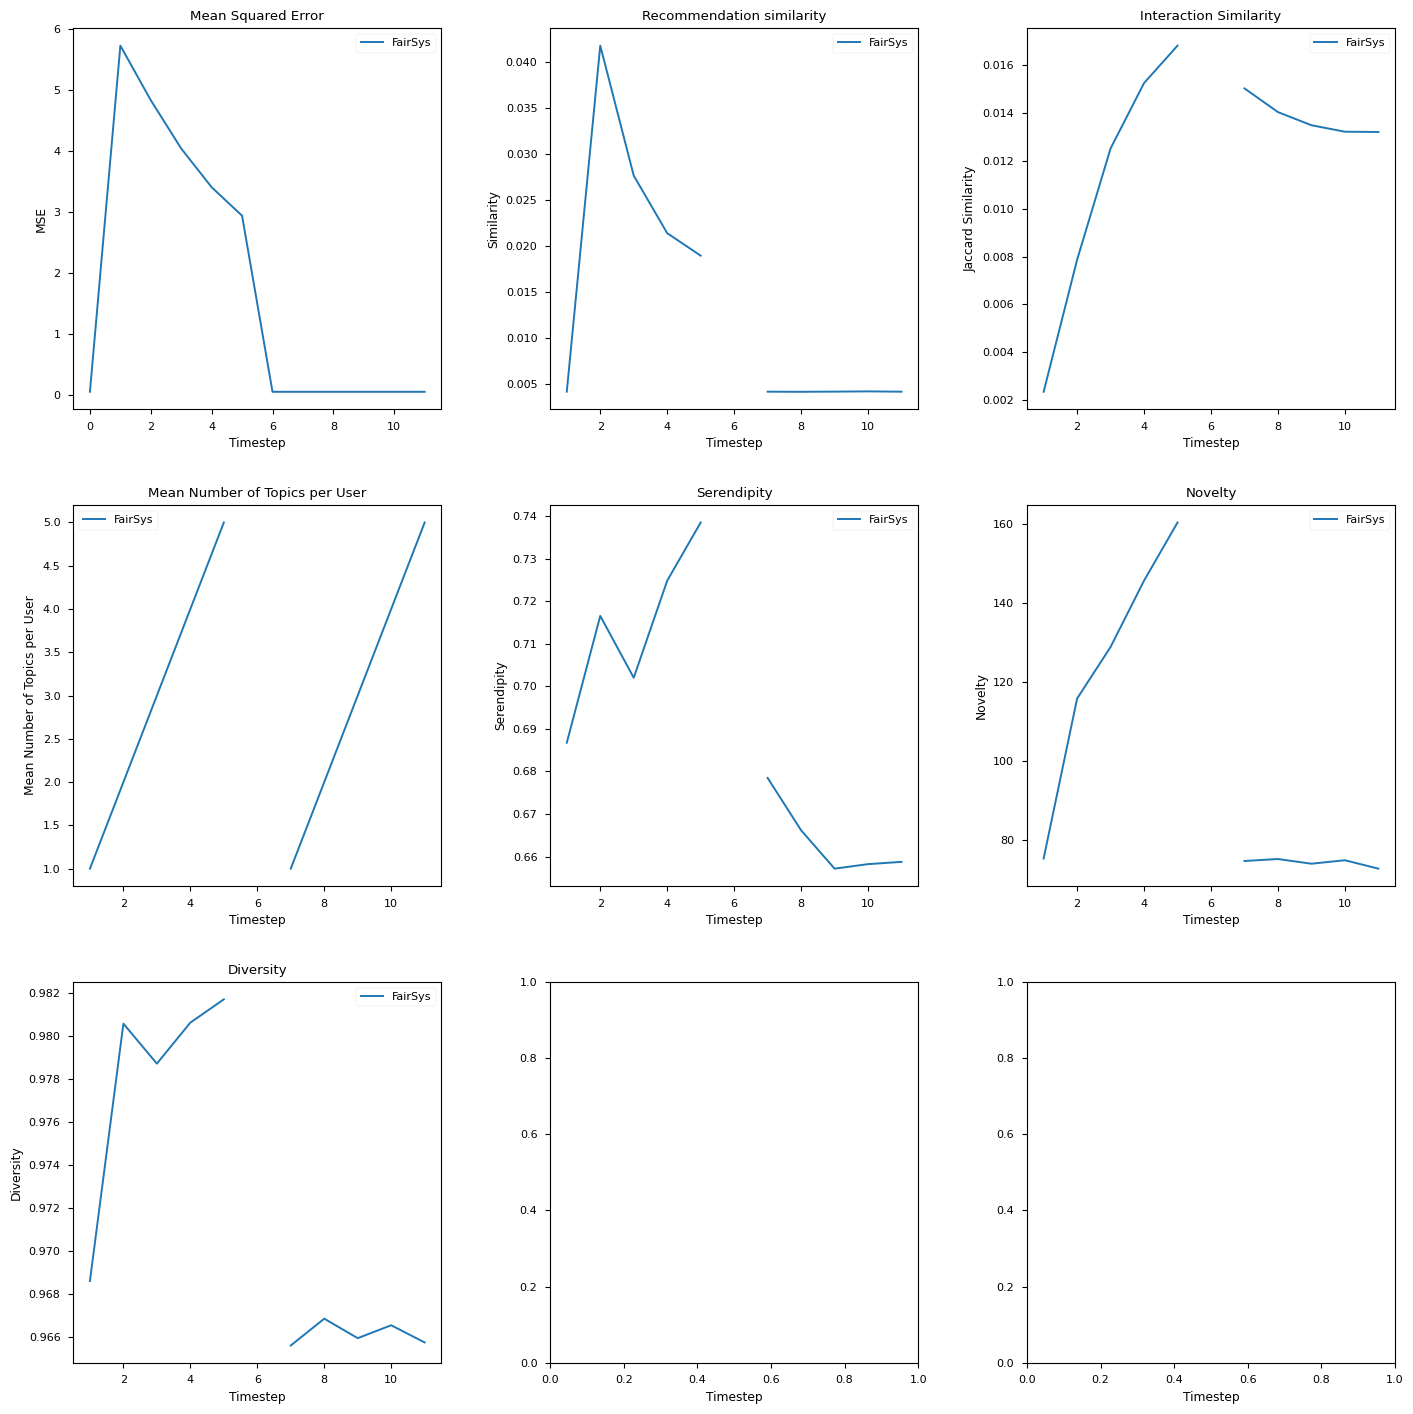

In [29]:
import src
reload(src.utils)
from src.utils import *
path = f'artefacts/fairsys_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs_{n_clusters}nClusters.csv'
fairsys_measurements_df = load_or_create_measurements_df(fairsys, 'cos_sim', path)
fairsys_measurements_df['model'] = 'FairSys'
plot_measurements([fairsys_measurements_df])

# Analysis

In [ ]:
timesteps=50
max_iter=500
nmf_solver='mu'
n_attrs=100
n_clusters=50

In [ ]:
path = f'artefacts/ml_myopic_prob_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs_{n_clusters}nClusters.csv'
myopic_prob_df = pd.read_csv(path, index_col=0)
myopic_prob_df['model'] = 'myopic_prob'

path = f'artefacts/ml_myopic_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs_{n_clusters}nClusters.csv'
myopic_df = pd.read_csv(path, index_col=0)
myopic_df['model'] = 'myopic'

path = f'artefacts/fairsys_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs_{n_clusters}nClusters.csv'
fairsys_df = pd.read_csv(path, index_col=0)
fairsys_df['model'] = 'fairsys'

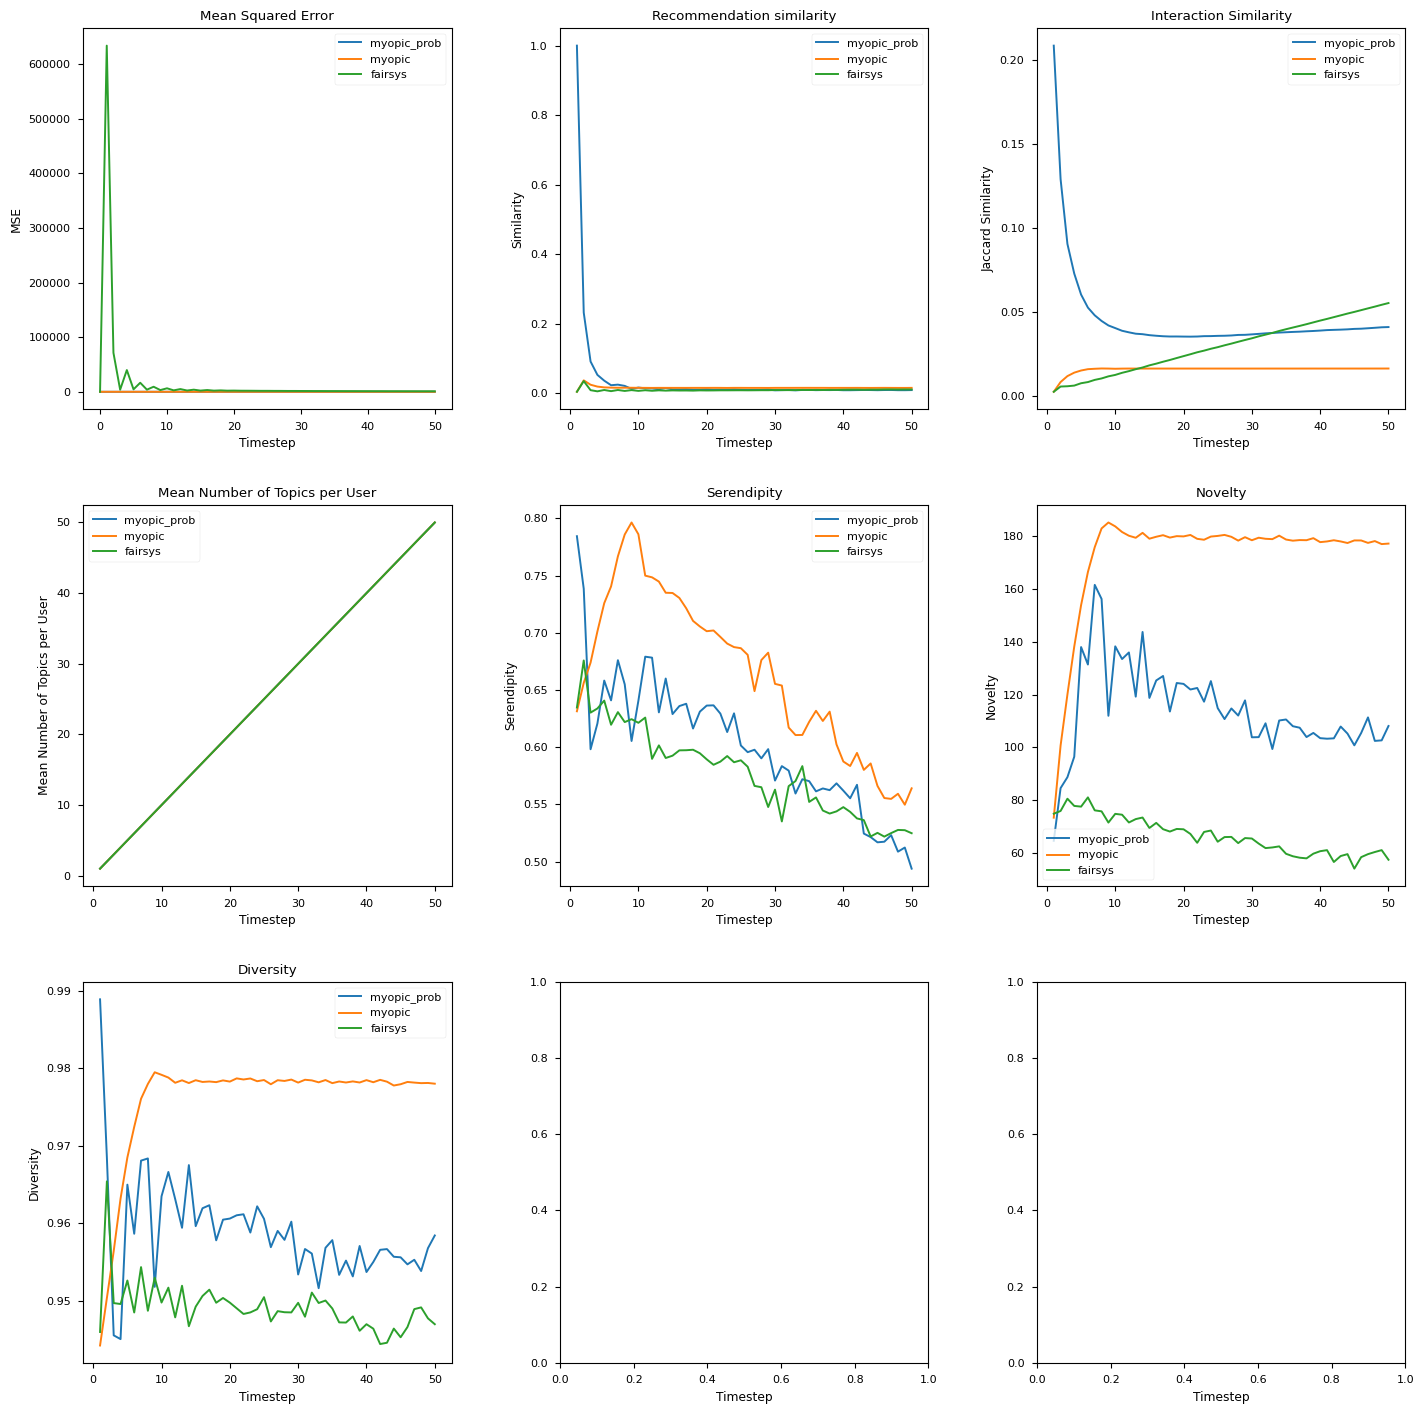

In [ ]:
plot_measurements([myopic_prob_df, myopic_df, fairsys_df])

In [ ]:
df

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,mean_num_topics,serendipity_metric,diversity_metric,novelty_metric,timesteps,model
0,NaN,0.048296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,myopic
1,[1. 0. 4. ... 0. 0. 0.],6.184458,-939.5,0.002374,0.004215,1.0,0.631389,0.944256,73.457849,1,myopic
2,[0. 2. 0. ... 0. 0. 0.],5.046164,31.0,0.008182,0.037077,2.0,0.656204,0.950383,100.730751,2,myopic
3,[0. 0. 1. ... 0. 0. 0.],4.167739,-19.5,0.011703,0.024523,3.0,0.673913,0.956439,120.020648,3,myopic
4,[1. 0. 0. ... 0. 0. 0.],3.493099,-6.5,0.013769,0.019206,4.0,0.701166,0.963203,138.130897,4,myopic
...,...,...,...,...,...,...,...,...,...,...,...
46,[3. 0. 1. ... 0. 0. 0.],1013.227930,-0.5,0.050939,0.010874,46.0,0.521845,0.946636,58.537375,46,fairsys
47,[2. 0. 0. ... 0. 0. 0.],1002.624744,0.5,0.051997,0.010958,47.0,0.524920,0.948945,59.678532,47,fairsys
48,[1. 0. 0. ... 0. 0. 0.],977.437750,-1.0,0.053033,0.010674,48.0,0.527678,0.949169,60.476920,48,fairsys
49,[2. 0. 1. ... 0. 0. 0.],970.235408,0.5,0.054120,0.010856,49.0,0.527466,0.947755,61.191404,49,fairsys
